# Model comparison



## Setup

In [1]:
import os
import sys
import dotenv
import json
from loguru import logger

# Append the models path in order to import the models
PROJECT_ROOT = os.path.join(os.getcwd(), 'src/')
print(PROJECT_ROOT)
sys.path.append(PROJECT_ROOT)

# Load env variables
dotenv.load_dotenv()

# Set log level INFO
logger.remove()
logger.add(sys.stderr, level="INFO")

/home/twanh/workspace/thesis/thesis-advent-of-agents/src/


1

In [2]:
# Import models from the system
from models.base_model import BaseLanguageModel
from models.gemini_model import GeminiLanguageModel
from models.openai_model import OpenAILanguageModel
from models.deepseek_model import DeepseekLanguageModel

### Load puzzles and input/outputs

In [3]:
# Get the correct paths
test_data_folder = os.path.join(PROJECT_ROOT, '..', 'experiments', 'test_data')
puzzles_folder = os.path.join(test_data_folder, 'puzzles/')
input_output_file = os.path.join(test_data_folder, 'answers2024.json')
puzzle_files = [os.path.join(puzzles_folder, f) for f in os.listdir(puzzles_folder) if os.path.isfile(os.path.join(puzzles_folder, f))]

In [4]:
# Create a datastructure were we can get by day
json_data = {}
with open(input_output_file, 'r') as f:
    json_data = {item['day']: item for item in json.load(f)}

puzzle_data = []
for file_path in puzzle_files:
    # Get the day of the puzzle file
    file_name = os.path.basename(file_path)
    day_str = file_name.split('_')[-1].split('.')[0]
    day = int(day_str)

    if day in json_data:
        with open(file_path, 'r') as f:
            puzzle_description = f.read()

        puzzle_info = {
            "year": json_data[day]['year'],
            "day": day,
            "description": puzzle_description,
            "input": json_data[day]['input'],
            "expected_output": json_data[day]['part1']
        }

        puzzle_data.append(puzzle_info)

# Sort by day
puzzle_data.sort(key=lambda x: x['day'])
print(len(puzzle_data)) # should be 25

25


### Model Configurations

| Agent          | Configuration 1 (Ultimate Power) | Configuration 2 (Speed) | Configuration 3 (Coding Reasoning) | Configuration 4 (Planning Reasoning) |
| :------------- | :------------------------------ | :----------------------- | :-------------------------------- | :----------------------------------- |
| **preprocessing** | Claude 3.5 Sonnet               | Gemini 2.0 Flash          | Gemini 2.0 Flash                  | Gemini 2.0 Flash                     |
| **retrieval**  | Gemini 2.5 Pro                  | Gemini 2.0 Flash          | Gemini 2.0 Flash                  | Gemini 2.0 Flash                     |
| **planning**   | o3 (Reasoning)                  | Claude 3.5 Haiku          | Gemini 2.0 Flash                  | Gemini 2.0 Flash Thinking (Reasoning) |
| **coding**     | GPT-4.1                         | Claude 3.5 Haiku          | Gemini 2.0 Flash Thinking (Reasoning) | Gemini 2.0 Flash                     |
| **debugging**  | Claude 3.7 Sonnet               | Gemini 2.0 Flash          | Gemini 2.0 Flash                  | Gemini 2.0 Flash                     |

1. Ultimate Power
Aim: Deploy top-tier models for optimal raw performance, leveraging best in class. This prioritizes high puzzle-solving success over speed or cost.
Strategy: Places o3 (your most powerful model, flagged as Reasoning:TRUE) at the critical planning stage and balances other critical stages with other state of the art models.
2. Speed
Aim: To maximize processing speed through the multi-agent system pipeline. This sacrifices complexity or more advanced reasoning agents for faster responses.
Strategy: Employs some of the most lightweight models across the multi-agent system such as Claude 3.5 Haiku to maximize efficiency and output speed.
3. Coding Reasoning
Aim: Investigates the performance impacts of applying reasoning capability only in the coding portion of the agent.
Strategy: This configuration places Gemini 2.0 Flash Thinking in the Coding role to evaluate how explicit reasoning at the code creation stage effects outputs, time, token usage, and error.
4. Planning Reasoning
Aim: Investigates the performance impacts of applying reasoning capability only in the planning portion of the agent.
Strategy: This configuration places Gemini 2.0 Flash Thinking in the Planning role to evaluate how explicit reasoning at the code creation stage effects outputs, time, token usage, and error.


In [2]:
from main import _get_model

# Configuration 1 (Ultimate Power)
config_ultimate_power = {
    "preprocessing": _get_model("claude-3-5-sonnet-20241022"),
    "retrieval": _get_model("gemini-2.5-pro-preview-05-06"),
    "planning": _get_model("o3"),  # Reasoning
    "coding": _get_model("gpt-4.1-2025-04-14"),
    "debugging": _get_model("claude-3-7-sonnet-20250219"),
}

# Configuration 2 (Speed)
config_speed = {
    "preprocessing": _get_model("gemini-2.0-flash"),
    "retrieval": _get_model("gemini-2.0-flash"),
    "planning": _get_model("claude-3-5-haiku-latest"),
    "coding": _get_model("claude-3-5-haiku-latest"),
    "debugging": _get_model("gemini-2.0-flash"),
}

# Configuration 3 (Coding Reasoning)
config_coding_reasoning = {
    "preprocessing": _get_model("gemini-2.0-flash"),
    "retrieval": _get_model("gemini-2.0-flash"),
    "planning": _get_model("gemini-2.0-flash"),
    "coding": _get_model("gemini-2.0-flash-thinking-exp-1219"),  # Reasoning
    "debugging": _get_model("gemini-2.0-flash"),
}

# Configuration 4 (Planning Reasoning)
config_planning_reasoning = {
    "preprocessing": _get_model("gemini-2.0-flash"),
    "retrieval": _get_model("gemini-2.0-flash"),
    "planning": _get_model("gemini-2.0-flash-thinking-exp-1219"),  # Reasoning
    "coding": _get_model("gemini-2.0-flash"),
    "debugging": _get_model("gemini-2.0-flash"),
}

# Configuration 5 (Planning&Code Reasoning)
config_plan_code_reasoning = {
    "preprocessing": _get_model("gemini-2.0-flash"),
    "retrieval": _get_model("gemini-2.0-flash"),
    "planning": _get_model("gemini-2.0-flash-thinking-exp-1219"),  # Reasoning
    "coding": _get_model("gemini-2.0-flash-thinking-exp-1219"), # Reasoning
    "debugging": _get_model("gemini-2.0-flash"),
}

# Dictionary collecting all configurations for testing
configurations_to_test = {
    #"ultimate_power": config_ultimate_power,
    # "speed": config_speed, # Disabled because claude (for now)
    #"coding_reasoning": config_coding_reasoning,
    #"planning_reasoning": config_planning_reasoning,
    config_plan_code_reasoning,
}

print(configurations_to_test)


TypeError: unhashable type: 'dict'

## System

In [6]:
from agents.base_agent import BaseAgent
from agents.coding_agent import CodingAgent
from agents.debugging_agent import DebuggingAgent
from agents.planning_agent import PlanningAgent
from agents.pre_processing_agent import PreProcessingAgent
from agents.retreival_agent import RetrievalAgent
from core.orchestrator import Orchestrator
from utils.util_types import AgentSettings
from core.state import MainState
from utils.util_types import Puzzle

In [7]:

def setup_system(config: dict[str, BaseLanguageModel], expected_output: str, puzzle_input: str):

    preprocessing_model = config["preprocessing"]
    retrieval_model = config["retrieval"]
    planning_model = config["planning"]
    coding_model = config["coding"]
    debugging_model = config["debugging"]

    agents = (
        (
            PreProcessingAgent(
                'preprocess', model=preprocessing_model,
            ),
            AgentSettings(enabled=True, can_debug=False),
        ),
        (
            RetrievalAgent(
                'retreival',
                model=retrieval_model,
                connection_string=os.getenv('DB_CONNECTION_STRING') or '',
                openai_key=os.getenv('OPENAI_API_KEY') or '',
                weights=None, # Use default weights
            ),
            AgentSettings(enabled=True, can_debug=False),
        ),
        (
            PlanningAgent(
                'planning',
                model=planning_model,
                n_plans=3, # Keep n_plans fixed for consistent comparison
            ),
            AgentSettings(enabled=True, can_debug=False),
        ),
        (
            CodingAgent('coding', model=coding_model),
            AgentSettings(enabled=True, can_debug=False),
        ),
        (
            DebuggingAgent(
                'debugging',
                model=debugging_model,
                expected_output=expected_output,
                puzzle_input=puzzle_input,
            ),
            AgentSettings(enabled=True, can_debug=True),
        ),
    )

    orchestrator = Orchestrator(agents, {})
    return orchestrator


In [ ]:
import time
def run_and_test_system(
    day: int,
    puzzle_desc: str,
    puzzle_input: str,
    expected_output: str,
    config: dict 
) -> dict[str, str|int|None]:

    orchestrator = setup_system(
        config,
        expected_output=expected_output,
        puzzle_input=puzzle_input
    )


    puzzle = Puzzle(
        description=puzzle_desc,
        solution=None,
        year=2024,
        day=day,
    )

    state = MainState(puzzle=puzzle)

    try:
        start_time = time.time()
        ret_state = orchestrator.solve_puzzle(state)
        end_time = time.time()
        return {
            'success': ret_state.is_solved,
            'day': day,
            'code': ret_state.final_code,
            'debug_attempts': ret_state.debug_attempts,
            'debug_suggestions': ret_state.debug_suggestions,
            'n_retreived_puzzles': len(ret_state.retreived_puzzles),
            'keywords': ','.join(ret_state.keywords),
            'concepts': ','.join(ret_state.underlying_concepts),
            'time': end_time - start_time
        }

    except Exception as e:
        print(f"Runtime error during puzzle solving for Day {day}: {e}")
        return {
            'success': False,
            'code': None,
            'day': day,
            'debug_attempts': None,
            'debug_suggestions': None,
            'n_retreived_puzzles': None,
            'keywords': None,
            'concepts': None,
            'time': None,
        }

In [12]:
import datetime
import pandas as pd
SAVE_DIR = os.path.join(PROJECT_ROOT, '../', 'experiments/', 'results/', 'model_comparison/')

def run_config(config: dict[str, BaseLanguageModel], config_name: str, puzzle_data):

    all_results = []
    for puzzle in puzzle_data:
        # Load puzzle
        puzzle_day = puzzle['day']
        puzzle_description = puzzle['description']
        input_ = puzzle['input']
        expected_ouptut = puzzle['expected_output']
        print(f"Running day {puzzle_day}")

        # RUn the tests
        results = run_and_test_system(
            puzzle_day,
            puzzle_description,
            input_,
            expected_ouptut,
            config,
        )

        results['config_name'] = config_name
        all_results.append(results)

    # Save the results
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f'comp-{config_name}-{timestamp}.csv'
    filepath =os.path.join(SAVE_DIR, filename)

    results_df = pd.DataFrame(all_results)
    print(f"Saving results for {config_name} to {filepath}")
    results_df.to_csv(filepath, index=False)
    
    return results_df

In [16]:
# Runn all configs

results_list = []
for config_name, config in configurations_to_test.items():

    print(f"----- Running config {config_name}")
    print(config)
    results_config = run_config(config, config_name, puzzle_data)
    results_list.append(results_config)

timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f'reasoning_configs-{timestamp}.csv'
filepath = os.path.join(SAVE_DIR, filename)
results = pd.concat(results_list)
results.to_csv(filepath, index=False)

2025-05-23 18:37:50.196 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-23 18:37:50.197 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess


----- Running config coding_reasoning
{'preprocessing': <models.gemini_model.GeminiLanguageModel object at 0x78e73df87320>, 'retrieval': <models.gemini_model.GeminiLanguageModel object at 0x78e73df696d0>, 'planning': <models.gemini_model.GeminiLanguageModel object at 0x78e73df6f0e0>, 'coding': <models.gemini_model.GeminiLanguageModel object at 0x78e73da8ec60>, 'debugging': <models.gemini_model.GeminiLanguageModel object at 0x78e73a568740>}
Running day 1


2025-05-23 18:37:52.792 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-23 18:38:06.873 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle10-2017. Skipping...
2025-05-23 18:38:06.878 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-23 18:38:06.881 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-23 18:38:06.883 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-23 18:38:12.654 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-23 18:38:18.535 | WARNING  | agents.planning_agent:_generate_solution_plan:98 - Could not extract markdown plan from response.generated_plan=[] ret="```markdown\n## 1. Overall Approach\nThe problem requires calculating the total distance between two lists of integers. The approach involves sorting both lists and then calculating the absolute difference between elements at corresponding ind

Running day 2


2025-05-23 18:38:39.179 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-23 18:39:08.857 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-23 18:39:08.860 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-23 18:39:08.861 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-23 18:39:16.645 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-23 18:39:23.420 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-23 18:39:30.797 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-23 18:39:59.480 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-23 18:39:59.482 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-23 18:39:59.484 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-23 18:39:59.566 | INFO     | agents.debugging_

Running day 3


2025-05-23 18:40:03.559 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-23 18:40:12.512 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle1-2017. Skipping...
2025-05-23 18:40:12.541 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle4-2017. Skipping...
2025-05-23 18:40:12.544 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-23 18:40:12.546 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-23 18:40:12.547 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-23 18:40:19.525 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-23 18:40:28.147 | WARNING  | agents.planning_agent:_get_confidence_score:59 - Could not decode json, Invalid control character at: line 3 column 281 (char 304)
2025-05-23 18:40:28.149 | WARNING  | agents.planning_agent:_get_confidence_score:61 - Retrying confiden

Running day 4


2025-05-23 18:41:20.051 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-23 18:41:44.157 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle17-2016. Skipping...
2025-05-23 18:41:44.161 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-23 18:41:44.163 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-23 18:41:44.166 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-23 18:41:53.230 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-23 18:42:01.543 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-23 18:42:10.789 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-23 18:42:34.525 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-23 18:42:34.529 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-23 1

Running day 5


2025-05-23 18:42:40.267 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-23 18:43:00.177 | WARNING  | agents.retreival_agent:process:130 - Could not decode json: e=JSONDecodeError('Expecting property name enclosed in double quotes: line 14 column 5 (char 3041)')
2025-05-23 18:43:00.178 | WARNING  | agents.base_agent:_invalid_response_retry:66 - Retrying 1/3 for retreival
2025-05-23 18:43:25.027 | WARNING  | agents.retreival_agent:process:130 - Could not decode json: e=JSONDecodeError("Expecting ',' delimiter: line 7 column 1881 (char 2389)")
2025-05-23 18:43:25.030 | WARNING  | agents.base_agent:_invalid_response_retry:66 - Retrying 2/3 for retreival
2025-05-23 18:43:52.879 | WARNING  | agents.retreival_agent:process:130 - Could not decode json: e=JSONDecodeError('Unterminated string starting at: line 21 column 15 (char 5607)')
2025-05-23 18:43:52.881 | WARNING  | agents.base_agent:_invalid_response_retry:66 - Retrying 3/3 for retreival
2025-05-23 18:44

Running day 6


2025-05-23 18:46:59.712 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-23 18:47:08.311 | WARNING  | agents.retreival_agent:process:130 - Could not decode json: e=JSONDecodeError('Expecting property name enclosed in double quotes: line 15 column 5 (char 3149)')
2025-05-23 18:47:08.312 | WARNING  | agents.base_agent:_invalid_response_retry:66 - Retrying 1/3 for retreival
2025-05-23 18:47:16.726 | WARNING  | agents.retreival_agent:process:130 - Could not decode json: e=JSONDecodeError('Invalid control character at: line 7 column 1217 (char 1830)')
2025-05-23 18:47:16.728 | WARNING  | agents.base_agent:_invalid_response_retry:66 - Retrying 2/3 for retreival
2025-05-23 18:47:42.701 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-23 18:47:42.705 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-23 18:47:42.707 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-23 18:47:50.042

Running day 7


2025-05-23 18:53:01.857 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-23 18:53:31.121 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-23 18:53:31.124 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-23 18:53:31.126 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-23 18:53:38.176 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-23 18:53:45.755 | WARNING  | agents.planning_agent:_get_confidence_score:59 - Could not decode json, Invalid control character at: line 3 column 606 (char 629)
2025-05-23 18:53:45.757 | WARNING  | agents.planning_agent:_get_confidence_score:61 - Retrying confidence score extraction
2025-05-23 18:53:47.292 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-23 18:53:54.574 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-23 18:55:27.574 | WARNING  | agents.coding_age

Running day 8


2025-05-23 18:58:21.863 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-23 18:58:46.006 | WARNING  | agents.retreival_agent:process:130 - Could not decode json: e=JSONDecodeError('Invalid control character at: line 19 column 641 (char 5231)')
2025-05-23 18:58:46.008 | WARNING  | agents.base_agent:_invalid_response_retry:66 - Retrying 1/3 for retreival
2025-05-23 18:59:11.506 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-23 18:59:11.509 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-23 18:59:11.510 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-23 18:59:24.817 | WARNING  | agents.planning_agent:_get_confidence_score:59 - Could not decode json, Invalid control character at: line 3 column 313 (char 336)
2025-05-23 18:59:24.818 | WARNING  | agents.planning_agent:_get_confidence_score:61 - Retrying confidence score extraction
2025-05-23 18:59:26.479 | INFO     | agen

Running day 9


2025-05-23 19:01:06.031 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-23 19:01:16.066 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle16-2017. Skipping...
2025-05-23 19:01:16.097 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle9-2016. Skipping...
2025-05-23 19:01:16.101 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-23 19:01:16.103 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-23 19:01:16.104 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-23 19:01:23.910 | WARNING  | agents.planning_agent:_generate_solution_plan:98 - Could not extract markdown plan from response.generated_plan=[] ret='## 1. Overall Approach\nThe problem requires parsing a string representing a disk map, simulating the rearrangement of file blocks by moving them to the leftmost free space, and then calculating a checksu

Running day 10


2025-05-23 19:20:12.704 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-23 19:20:17.065 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle19-2017. Skipping...
2025-05-23 19:20:35.336 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-23 19:20:35.338 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-23 19:20:35.340 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-23 19:20:42.990 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-23 19:20:50.092 | WARNING  | agents.planning_agent:_generate_solution_plan:98 - Could not extract markdown plan from response.generated_plan=[] ret="## 1. Overall Approach\nThe problem asks us to traverse a topographic map represented by a grid of elevation values, starting from trailheads (elevation 0) and following paths that increase elevation by exactly 1 at each step until reaching el

Running day 11


2025-05-23 19:22:13.841 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-23 19:22:15.772 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle5-2017. Skipping...
2025-05-23 19:22:28.167 | WARNING  | agents.retreival_agent:process:130 - Could not decode json: e=JSONDecodeError('Invalid \\escape: line 13 column 811 (char 2641)')
2025-05-23 19:22:28.168 | WARNING  | agents.base_agent:_invalid_response_retry:66 - Retrying 1/3 for retreival
2025-05-23 19:22:30.528 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle5-2017. Skipping...
2025-05-23 19:22:39.039 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-23 19:22:39.042 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-23 19:22:39.043 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-23 19:22:44.793 | WARNING  | agents.planning_agent:_generate_solution_plan:9

Running day 12


2025-05-23 19:28:32.537 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-23 19:28:35.499 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle19-2017. Skipping...
2025-05-23 19:28:43.993 | WARNING  | agents.retreival_agent:process:130 - Could not decode json: e=JSONDecodeError('Invalid control character at: line 13 column 1234 (char 3026)')
2025-05-23 19:28:43.995 | WARNING  | agents.base_agent:_invalid_response_retry:66 - Retrying 1/3 for retreival
2025-05-23 19:28:46.535 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle19-2017. Skipping...
2025-05-23 19:29:05.084 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-23 19:29:05.089 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-23 19:29:05.092 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-23 19:29:13.673 | INFO     | agents.planning_agent:process:15

Running day 13


2025-05-23 19:30:56.025 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-23 19:30:59.763 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle15-2016. Skipping...
2025-05-23 19:31:14.184 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-23 19:31:14.186 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-23 19:31:14.187 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-23 19:31:28.474 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-23 19:31:36.844 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-23 19:31:48.679 | WARNING  | agents.planning_agent:_get_confidence_score:59 - Could not decode json, Invalid control character at: line 3 column 305 (char 328)
2025-05-23 19:31:48.681 | WARNING  | agents.planning_agent:_get_confidence_score:61 - Retrying confidence score extraction
2025-05-23 19:31:5

Running day 14


2025-05-23 19:35:00.626 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-23 19:35:09.882 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle13-2017. Skipping...
2025-05-23 19:35:19.673 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-23 19:35:19.676 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-23 19:35:19.677 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-23 19:35:28.271 | WARNING  | agents.planning_agent:_generate_solution_plan:98 - Could not extract markdown plan from response.generated_plan=[] ret="## 1. Overall Approach\nThe problem requires simulating the movement of robots in a grid with wrap-around edges. The main approach is to parse the input to extract each robot's initial position and velocity. Then, for the specified number of steps (100), update each robot's position, applying wrap-around logic. Finally, count the nu

Running day 15


2025-05-23 19:48:12.940 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-23 19:48:43.188 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-23 19:48:43.191 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-23 19:48:43.192 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-23 19:48:50.714 | WARNING  | agents.planning_agent:_generate_solution_plan:98 - Could not extract markdown plan from response.generated_plan=[] ret="## 1. Overall Approach\nSimulate the robot's movement and box pushing on a grid. Track the positions of boxes after all moves are executed, then calculate the sum of their GPS coordinates.\n\n## 2. Data Structures\n*   `grid`: A 2D list (list of lists) representing the warehouse layout. Each cell will contain either '#'(wall), '.'(empty), '@'(robot), or 'O'(box).\n*   `robot_position`: A tuple `(row, col)` representing the robot's current position in the grid.\

Running day 16


2025-05-23 19:57:25.823 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-23 19:57:28.799 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle24-2016. Skipping...
2025-05-23 19:57:41.673 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-23 19:57:41.676 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-23 19:57:41.678 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-23 19:57:52.342 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-23 19:58:01.866 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-23 19:58:13.644 | WARNING  | agents.planning_agent:_get_confidence_score:59 - Could not decode json, Invalid control character at: line 3 column 392 (char 415)
2025-05-23 19:58:13.646 | WARNING  | agents.planning_agent:_get_confidence_score:61 - Retrying confidence score extraction
2025-05-23 19:58:1

Running day 17


2025-05-23 20:01:27.390 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-23 20:01:35.416 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle23-2016. Skipping...
2025-05-23 20:01:41.731 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-23 20:01:41.735 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-23 20:01:41.737 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-23 20:01:52.103 | WARNING  | agents.planning_agent:_generate_solution_plan:98 - Could not extract markdown plan from response.generated_plan=[] ret='## 1. Overall Approach\nSimulate the execution of a 3-bit computer program by parsing the program and initial register values from the input, then iteratively executing instructions based on their opcodes and operands. Handle the different operand types (literal and combo) and instructions (adv, bxl, bst, jnz, bxc, out, bdv, cdv) ac

Running day 18


2025-05-23 20:09:30.922 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-23 20:09:53.629 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-23 20:09:53.633 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-23 20:09:53.635 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-23 20:10:02.682 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-23 20:10:12.618 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-23 20:10:21.856 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-23 20:10:56.244 | WARNING  | agents.coding_agent:process:79 - Could not decode JSON, e=JSONDecodeError("Expecting ',' delimiter: line 2 column 6669 (char 6670)")
2025-05-23 20:10:56.246 | WARNING  | agents.base_agent:_invalid_response_retry:66 - Retrying 1/3 for coding
2025-05-23 20:11:21.280 | INFO     | core.orchestrator:solve_puzzle

Running day 19


2025-05-23 20:11:34.850 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-23 20:11:53.287 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-23 20:11:53.291 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-23 20:11:53.293 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-23 20:12:01.122 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-23 20:12:10.073 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-23 20:12:18.988 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-23 20:12:30.870 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-23 20:12:30.872 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-23 20:12:30.876 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-23 20:12:31.427 | INFO     | agents.debugging_

Running day 20


2025-05-23 20:12:35.669 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-23 20:13:04.459 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-23 20:13:04.463 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-23 20:13:04.465 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-23 20:13:15.534 | WARNING  | agents.planning_agent:_generate_solution_plan:98 - Could not extract markdown plan from response.generated_plan=[] ret='## 1. Overall Approach\nThe problem requires finding the number of "cheats" that save at least 100 picoseconds compared to the shortest path without cheating. The core idea is to first calculate the shortest path from start to end without cheating. Then, iterate through all possible cheat start and end locations on the track. For each possible cheat, calculate the shortest path from start to cheat start, then the distance from cheat start to cheat end (which is

Running day 21


2025-05-23 20:25:33.321 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-23 20:25:35.841 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle17-2016. Skipping...
2025-05-23 20:25:35.870 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle13-2016. Skipping...
2025-05-23 20:25:42.472 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-23 20:25:42.475 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-23 20:25:42.477 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-23 20:25:53.493 | WARNING  | agents.planning_agent:_generate_solution_plan:98 - Could not extract markdown plan from response.generated_plan=[] ret='## 1. Overall Approach\nThe problem requires finding the shortest sequence of moves on a directional keypad to type a sequence of characters on a numeric keypad. We need to calculate the "complexity" of 

Running day 22


2025-05-23 20:49:22.335 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-23 20:49:35.814 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle15-2017. Skipping...
2025-05-23 20:49:52.598 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-23 20:49:52.599 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-23 20:49:52.600 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-23 20:49:59.614 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-23 20:50:07.104 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-23 20:50:14.384 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-23 20:51:39.221 | WARNING  | agents.coding_agent:process:79 - Could not decode JSON, e=JSONDecodeError('Invalid control character at: line 2 column 18 (char 19)')
2025-05-23 20:51:39.223 | WARNING  | agents

Running day 23


2025-05-23 20:53:40.495 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-23 20:53:40.499 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess
2025-05-23 20:53:44.102 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-23 20:53:58.655 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle7-2017. Skipping...
2025-05-23 20:54:09.992 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-23 20:54:09.997 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-23 20:54:09.999 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-23 20:54:18.713 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-23 20:54:27.824 | WARNING  | agents.planning_agent:_get_confidence_score:59 - Could not decode json, Invalid control character at: line 3 column 570 (char 593)
2025-05-23 20:54:27.826 | WARNING 

Running day 24


2025-05-23 20:57:54.697 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-23 20:57:59.633 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle7-2017. Skipping...
2025-05-23 20:58:11.070 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-23 20:58:11.074 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-23 20:58:11.076 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-23 20:58:22.039 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-23 20:58:33.285 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-23 20:58:43.432 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-23 20:59:01.754 | WARNING  | agents.coding_agent:process:79 - Could not decode JSON, e=JSONDecodeError("Expecting ',' delimiter: line 2 column 1275 (char 1276)")
2025-05-23 20:59:01.757 | WARNING  | agents.b

Running day 25


2025-05-23 21:06:06.559 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-23 21:06:15.895 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle16-2017. Skipping...
2025-05-23 21:06:15.924 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle1-2017. Skipping...
2025-05-23 21:06:15.928 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-23 21:06:15.930 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-23 21:06:15.932 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-23 21:06:24.544 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-23 21:06:34.785 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-23 21:06:43.925 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-23 21:08:24.765 | WARNING  | models.gemini_model:prompt:32 - Received unexpe

Saving results for coding_reasoning to /home/twanh/workspace/thesis/thesis-advent-of-agents/src/../experiments/results/model_comparison/comp-coding_reasoning-20250523_212538.csv
----- Running config planning_reasoning
{'preprocessing': <models.gemini_model.GeminiLanguageModel object at 0x78e73a5691f0>, 'retrieval': <models.gemini_model.GeminiLanguageModel object at 0x78e73a569ca0>, 'planning': <models.gemini_model.GeminiLanguageModel object at 0x78e73a56aab0>, 'coding': <models.gemini_model.GeminiLanguageModel object at 0x78e73a56b830>, 'debugging': <models.gemini_model.GeminiLanguageModel object at 0x78e73a560320>}
Running day 1


2025-05-23 21:25:40.542 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-23 21:26:00.248 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-23 21:26:00.251 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-23 21:26:00.253 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-23 21:26:08.125 | WARNING  | agents.planning_agent:_generate_solution_plan:98 - Could not extract markdown plan from response.generated_plan=[] ret='## 1. Overall Approach\nThe problem requires processing two lists of numbers presented side-by-side, sorting each list independently, pairing the elements at corresponding indices after sorting, calculating the absolute difference for each pair, and summing these differences. The core approach will be to parse the input into two lists, sort both lists, iterate through the sorted lists, calculate the absolute difference for each pair, and accumulate the sum.\n\n

Running day 2


2025-05-23 21:26:48.250 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-23 21:26:57.014 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle1-2015. Skipping...
2025-05-23 21:27:04.657 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-23 21:27:04.661 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-23 21:27:04.664 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-23 21:27:26.360 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-23 21:27:40.289 | WARNING  | agents.planning_agent:_generate_solution_plan:98 - Could not extract markdown plan from response.generated_plan=[] ret='## 1. Overall Approach\nThe problem requires counting "safe" reports from a given list. A report is safe if it satisfies two conditions: its levels are strictly monotonic (all increasing or all decreasing) and the absolute difference between an

Running day 3


2025-05-23 21:28:20.774 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-23 21:28:32.626 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle1-2017. Skipping...
2025-05-23 21:28:32.658 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle4-2017. Skipping...
2025-05-23 21:28:32.661 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-23 21:28:32.664 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-23 21:28:32.667 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-23 21:28:54.479 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-23 21:29:12.933 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-23 21:29:35.259 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-23 21:29:38.946 | INFO     | core.orchestrator:solve_puzzle:58 - Running agen

Running day 4


2025-05-23 21:29:39.240 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-23 21:29:39.241 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess
2025-05-23 21:29:42.016 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-23 21:29:59.018 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-23 21:29:59.021 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-23 21:29:59.024 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-23 21:30:20.722 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-23 21:30:39.973 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-23 21:30:59.437 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-23 21:31:03.625 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-23 21:31:03.628 | INFO     | agents.debu

Running day 5


2025-05-23 21:31:08.371 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-23 21:31:34.463 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-23 21:31:34.468 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-23 21:31:34.470 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-23 21:31:51.324 | WARNING  | agents.planning_agent:_generate_solution_plan:98 - Could not extract markdown plan from response.generated_plan=[] ret='## 1. Overall Approach\nThe problem requires validating a series of page updates against a set of ordering rules and then summing the middle page numbers of only the valid updates. The core strategy will be to parse the rules and the updates separately. For each update, we will check if it violates any ordering rule where both pages involved in the rule are present in that specific update. If an update is valid, we identify its middle page number and add it to 

Running day 6


2025-05-23 21:33:04.157 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-23 21:33:28.678 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-23 21:33:28.682 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-23 21:33:28.684 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-23 21:34:03.141 | WARNING  | agents.planning_agent:_generate_solution_plan:98 - Could not extract markdown plan from response.generated_plan=[] ret='## 1. Overall Approach\nSimulate the guard\'s movement step by step on the grid according to the defined patrol protocol. The protocol involves checking the cell directly in front and either turning right if blocked (by an obstacle or grid edge) or moving forward otherwise. Keep track of all distinct grid positions visited during the simulation. The simulation continues until the guard moves to a position outside the grid boundaries. The final answer is the tot

Running day 7


2025-05-23 21:35:31.410 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-23 21:35:50.670 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-23 21:35:50.676 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-23 21:35:50.678 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-23 21:36:12.987 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-23 21:36:35.104 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-23 21:37:07.458 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-23 21:37:12.593 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-23 21:37:12.597 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-23 21:37:12.600 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-23 21:37:12.796 | INFO     | agents.debugging_

Running day 8


2025-05-23 21:37:16.681 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-23 21:37:18.407 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle11-2017. Skipping...
2025-05-23 21:37:26.510 | WARNING  | agents.retreival_agent:process:130 - Could not decode json: e=JSONDecodeError('Invalid control character at: line 13 column 42 (char 3894)')
2025-05-23 21:37:26.511 | WARNING  | agents.base_agent:_invalid_response_retry:66 - Retrying 1/3 for retreival
2025-05-23 21:37:28.926 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle11-2017. Skipping...
2025-05-23 21:37:36.956 | WARNING  | agents.retreival_agent:process:130 - Could not decode json: e=JSONDecodeError('Invalid \\escape: line 7 column 1046 (char 1665)')
2025-05-23 21:37:36.958 | WARNING  | agents.base_agent:_invalid_response_retry:66 - Retrying 2/3 for retreival
2025-05-23 21:37:39.302 | WARNING  | agents.retreival_agent:process:81 - 

Running day 9


2025-05-23 21:40:30.783 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-23 21:40:30.784 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess
2025-05-23 21:40:33.936 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-23 21:40:41.097 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle9-2016. Skipping...
2025-05-23 21:40:48.855 | WARNING  | agents.retreival_agent:process:130 - Could not decode json: e=JSONDecodeError('Invalid control character at: line 7 column 1730 (char 2393)')
2025-05-23 21:40:48.857 | WARNING  | agents.base_agent:_invalid_response_retry:66 - Retrying 1/3 for retreival
2025-05-23 21:40:56.786 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle9-2016. Skipping...
2025-05-23 21:41:04.284 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-23 21:41:04.287 | INFO     | agents.planning_age

Running day 10


2025-05-23 21:45:40.708 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-23 21:45:43.059 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle19-2017. Skipping...
2025-05-23 21:45:56.561 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-23 21:45:56.562 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-23 21:45:56.563 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-23 21:46:29.034 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-23 21:46:59.141 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-23 21:47:32.379 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-23 21:47:37.445 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-23 21:47:37.447 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-23 2

Running day 11


2025-05-23 21:47:41.360 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-23 21:47:44.112 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle5-2017. Skipping...
2025-05-23 21:47:59.969 | WARNING  | agents.retreival_agent:process:130 - Could not decode json: e=JSONDecodeError('Invalid control character at: line 7 column 158 (char 812)')
2025-05-23 21:47:59.971 | WARNING  | agents.base_agent:_invalid_response_retry:66 - Retrying 1/3 for retreival
2025-05-23 21:48:02.104 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle5-2017. Skipping...
2025-05-23 21:48:15.943 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-23 21:48:15.948 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-23 21:48:15.951 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-23 21:48:36.686 | INFO     | agents.planning_agent:process:152 - C

Running day 12


2025-05-23 21:49:54.249 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-23 21:50:19.895 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-23 21:50:19.898 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-23 21:50:19.900 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-23 21:50:46.572 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-23 21:51:24.152 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-23 21:51:49.561 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-23 21:51:55.169 | WARNING  | agents.coding_agent:process:79 - Could not decode JSON, e=JSONDecodeError("Expecting ',' delimiter: line 2 column 3288 (char 3289)")
2025-05-23 21:51:55.171 | WARNING  | agents.base_agent:_invalid_response_retry:66 - Retrying 1/3 for coding
2025-05-23 21:52:00.700 | INFO     | core.orchestrator:solve_puzzle

Running day 13


2025-05-23 21:52:05.635 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-23 21:52:07.592 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle15-2016. Skipping...
2025-05-23 21:52:20.275 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-23 21:52:20.278 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-23 21:52:20.283 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-23 21:52:47.666 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-23 21:53:14.287 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-23 21:53:51.618 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-23 21:53:56.741 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-23 21:53:56.744 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-23 2

Running day 14


2025-05-23 21:55:03.756 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-23 21:55:12.553 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle13-2017. Skipping...
2025-05-23 21:55:20.296 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-23 21:55:20.300 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-23 21:55:20.302 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-23 21:55:44.664 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-23 21:56:06.783 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-23 21:56:48.513 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-23 21:56:55.535 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-23 21:56:55.537 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-23 2

Running day 15


2025-05-23 21:57:02.494 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-23 21:57:25.427 | WARNING  | agents.retreival_agent:process:130 - Could not decode json: e=JSONDecodeError('Invalid \\escape: line 7 column 844 (char 1468)')
2025-05-23 21:57:25.428 | WARNING  | agents.base_agent:_invalid_response_retry:66 - Retrying 1/3 for retreival
2025-05-23 21:57:52.881 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-23 21:57:52.886 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-23 21:57:52.890 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-23 21:58:17.334 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-23 21:58:42.843 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-23 21:59:12.337 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-23 21:59:20.116 | WARNING  | agents.coding_agent:process:79 

Running day 16


2025-05-23 22:01:19.220 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-23 22:01:30.623 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle13-2016. Skipping...
2025-05-23 22:01:30.652 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle17-2016. Skipping...
2025-05-23 22:01:30.656 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-23 22:01:30.659 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-23 22:01:30.660 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-23 22:01:56.531 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-23 22:02:25.469 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-23 22:02:52.099 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-23 22:03:00.607 | INFO     | core.orchestrator:solve_puzzle:58 - Running ag

Running day 17


2025-05-23 22:03:06.475 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-23 22:03:16.031 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle23-2017. Skipping...
2025-05-23 22:03:20.561 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-23 22:03:20.567 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-23 22:03:20.571 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-23 22:04:02.131 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-23 22:04:31.211 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-23 22:04:58.051 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-23 22:05:05.414 | WARNING  | agents.coding_agent:process:79 - Could not decode JSON, e=JSONDecodeError('Unterminated string starting at: line 2 column 11 (char 12)')
2025-05-23 22:05:05.415 | WARNING  | age

Running day 18


2025-05-23 22:07:08.768 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-23 22:07:11.325 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle24-2016. Skipping...
2025-05-23 22:07:23.510 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-23 22:07:23.513 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-23 22:07:23.515 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-23 22:07:47.411 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-23 22:08:08.669 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-23 22:08:30.337 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-23 22:08:35.023 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-23 22:08:35.025 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-23 2

Running day 19


2025-05-23 22:08:38.461 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-23 22:08:56.388 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-23 22:08:56.393 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-23 22:08:56.395 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-23 22:09:15.253 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-23 22:09:30.086 | WARNING  | agents.planning_agent:_generate_solution_plan:98 - Could not extract markdown plan from response.generated_plan=[] ret='## 1. Overall Approach\nThe problem is a variation of the classic "Word Break" problem. We need to determine if each given design string can be segmented into a sequence of strings from the available towel patterns. This can be efficiently solved using recursion with memoization (dynamic programming) or an iterative dynamic programming approach. We will use recursion with

Running day 20


2025-05-23 22:10:35.729 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-23 22:10:42.323 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle24-2016. Skipping...
2025-05-23 22:10:48.019 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-23 22:10:48.024 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-23 22:10:48.026 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-23 22:12:05.129 | WARNING  | agents.planning_agent:_get_confidence_score:59 - Could not decode json, Expecting ',' delimiter: line 3 column 2583 (char 2606)
2025-05-23 22:12:05.131 | WARNING  | agents.planning_agent:_get_confidence_score:61 - Retrying confidence score extraction
2025-05-23 22:12:22.227 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-23 22:12:54.485 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-23 22:13:34.2

Running day 21


2025-05-23 22:13:46.713 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-23 22:14:11.324 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-23 22:14:11.330 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-23 22:14:11.333 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-23 22:15:52.468 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-23 22:18:07.024 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-23 22:19:46.080 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-23 22:20:00.917 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-23 22:20:00.918 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-23 22:20:00.920 | INFO     | agents.debugging_agent:_run_code:307 - Running code
2025-05-23 22:20:01.001 | WARNING  | agents.debugging_

Running day 22


2025-05-23 22:22:18.088 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-23 22:22:20.408 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle15-2017. Skipping...
2025-05-23 22:22:35.835 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-23 22:22:35.839 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-23 22:22:35.841 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-23 22:22:57.031 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-23 22:23:16.381 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-23 22:23:40.044 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-23 22:23:44.274 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-23 22:23:44.276 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-23 2

Running day 23


2025-05-23 22:23:50.405 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-23 22:23:53.041 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle7-2017. Skipping...
2025-05-23 22:24:06.175 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-23 22:24:06.180 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-23 22:24:06.182 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-23 22:24:27.157 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-23 22:24:46.650 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-23 22:25:09.889 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-23 22:25:12.964 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-23 22:25:12.967 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-23 22

Running day 24


2025-05-23 22:25:37.377 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-23 22:25:39.855 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle10-2016. Skipping...
2025-05-23 22:25:52.060 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-23 22:25:52.065 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-23 22:25:52.066 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-23 22:26:20.928 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-23 22:26:47.144 | INFO     | agents.planning_agent:process:152 - Creating plan 3/3
2025-05-23 22:27:12.475 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: coding
2025-05-23 22:27:23.328 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: debugging
2025-05-23 22:27:23.329 | INFO     | agents.debugging_agent:_run_test:337 - Running code with test case
2025-05-23 2

Running day 25


2025-05-23 22:27:23.641 | INFO     | core.retreival:init_db:154 - Database initialization complete.
2025-05-23 22:27:23.643 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: preprocess
2025-05-23 22:27:27.573 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: retreival
2025-05-23 22:27:33.744 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle1-2017. Skipping...
2025-05-23 22:27:33.775 | WARNING  | agents.retreival_agent:process:81 - Did not find any solutions for puzzle16-2017. Skipping...
2025-05-23 22:27:33.778 | INFO     | core.orchestrator:solve_puzzle:58 - Running agent: planning
2025-05-23 22:27:33.780 | INFO     | agents.planning_agent:process:149 - Generating 3 plans
2025-05-23 22:27:33.781 | INFO     | agents.planning_agent:process:152 - Creating plan 1/3
2025-05-23 22:28:03.687 | INFO     | agents.planning_agent:process:152 - Creating plan 2/3
2025-05-23 22:29:02.012 | INFO     | agents.planning_agent:process:152 

Saving results for planning_reasoning to /home/twanh/workspace/thesis/thesis-advent-of-agents/src/../experiments/results/model_comparison/comp-planning_reasoning-20250523_223049.csv


## Analysis

### Setup and Load Data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
textwidth = 8.3
aspect_ratio = 6/8
scale = 1.0
width = textwidth * scale
height = width * aspect_ratio

# GRAPH SAVE DIR
FIGURE_SAVE_DIR = os.path.join(PROJECT_ROOT, '../', 'figures/', 'model_comparision/')

def save_fig(plot, name):
    plot.savefig(os.path.join(os.path.abspath(FIGURE_SAVE_DIR), f'{name}.png'), dpi=300, bbox_inches='tight')
    plot.savefig(os.path.join(os.path.abspath(FIGURE_SAVE_DIR), f'{name}.pdf'), dpi=300, bbox_inches='tight')

ug_palette_dict = {
    'red': '#dc002d',
    'cyan': '#009CEF',
    'purple': '#772D68',
    'green': '#60B669',
    'pink': '#EC6581',
    'aqua': '#35B6B4',
    'yellow': '#FFDC64',
    'black': '#000000',
    'white': '#FFFFFF',
    'light_gray': '#D3D3D3' # Added for failure states
}

# Example of setting a default color cycle if you want
from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler(color=[
    ug_palette_dict['red'],
    ug_palette_dict['cyan'],
    ug_palette_dict['green'],
    ug_palette_dict['purple'],
    ug_palette_dict['yellow'],
    ug_palette_dict['pink'],
    ug_palette_dict['aqua']
])

In [4]:
RESULTS_DIR = os.path.join(PROJECT_ROOT, '../', 'experiments/', 'results/', 'model_comparison/')

In [5]:
# The first run did not save the day
# However the index+1 is the day since days are sorted
file_name = 'comp-ultimate_power-20250520_162430.csv' 
file_path = os.path.join(RESULTS_DIR, file_name)

# Add day column which is index + 1
wrong_df = pd.read_csv(file_path)
wrong_df['day'] = wrong_df.index + 1
wrong_df.head()

# Save the file
out_file_name = 'comp-ultimate_power-fix-20250520_162430.csv' 
out_file_path = os.path.join(RESULTS_DIR, out_file_name)
wrong_df.to_csv(out_file_path, index=False)


In [6]:
# Load all the individual run files and combine them into one dataframe
result_files = (
    'comp-ultimate_power-fix-20250520_162430.csv', # Ultimate power (first run)
    'reasoning_configs-20250523_223049.csv',
    'reasoning_configs-code-plan20250526_131032.csv'
)

df_list = []
for file in result_files:
    loaded = pd.read_csv(os.path.join(RESULTS_DIR, file))
    df_list.append(loaded)

df = pd.concat(df_list)
print(df.head())

   success                                               code  debug_attempts  \
0     True  """\nAdvent of Code Day 1: Historian Hysteria ...               0   
1     True  """\nAdvent of Code 2020 Day 2: Red-Nosed Repo...               0   
2     True  """\nAdvent of Code Day 3: Mull It Over\nParse...               0   
3     True  """\nAdvent of Code - Ceres Search (Find all "...               0   
4     True  """\nAdvent of Code 2023 Day 5: Print Queue\nS...               0   

  debug_suggestions  n_retreived_puzzles  \
0                []                    1   
1                []                    2   
2                []                    1   
3                []                    3   
4                []                    2   

                                            keywords  \
0  array processing,sorting,numerical computation...   
1  sequence validation,number sequence,array proc...   
2  string parsing,pattern matching,arithmetic,inp...   
3  grid,2D array,pattern

In [7]:
result = (
    df.groupby('config_name')
    .agg(
        total_puzzles=('success', 'count'),
        correct_puzzles=('success', 'sum')
    )
    .assign(success_rate=lambda x: x['correct_puzzles'] / x['total_puzzles'])
    .reset_index()
)

print(result[['config_name', 'success_rate']])

           config_name  success_rate
0  code_plan_reasoning          0.76
1     coding_reasoning          0.64
2   planning_reasoning          0.76
3       ultimate_power          0.96


### Analyze the results

#### Success Rate By Configuration

Success Rates by Configuration:
\begin{tabular}{lrrr}
\toprule
Configuration & Success Rate (%) & Avg. Time (s) & Avg. Debug Attempts \\
\midrule
Config 1 (Power) & 96 & 706.400000 & 0.400000 \\
Config 2 (Planning Reasoning) & 76 & 156.300000 & 1.600000 \\
Config 3 (Coding Reasoning) & 64 & 402.600000 & 2.900000 \\
Config 4 (P&C Reasoning) & 76 & 326.300000 & 2.200000 \\
\bottomrule
\end{tabular}



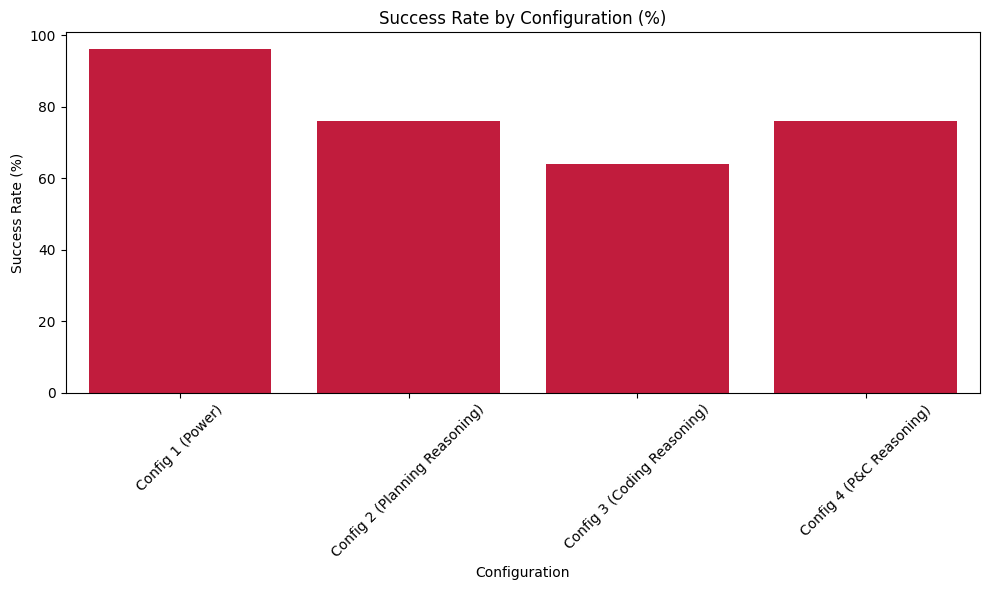

In [8]:
# Calculate success rates by configuration
# Calculate success rates and average time by configuration
success_by_config = (
    df.groupby('config_name')
      .agg(
          Success_Rate=('success', 'mean'),
#          Number_of_Puzzles=('success', 'count'),
          Avg_Time_s=('time', 'mean'),
          Avg_Debug =  ('debug_attempts', 'mean'),
      )
      .reset_index()
)

# Convert success rate to percentage
success_by_config['Success_Rate'] = success_by_config['Success_Rate'] * 100

success_by_config['Success_Rate'] = success_by_config['Success_Rate'].round(0).astype(int)
success_by_config['Avg_Time_s'] = success_by_config['Avg_Time_s'].round(1)
success_by_config['Avg_Debug'] = success_by_config['Avg_Debug'].round(1)

# Rename the columns
success_by_config = success_by_config.rename(
    columns={
        'config_name': 'Configuration',
        'Success_Rate': 'Success Rate (%)',
#        'Number_of_Puzzles': 'Number of Puzzles',
        'Avg_Time_s': 'Avg. Time (s)',
        'Avg_Debug': 'Avg. Debug Attempts',
    }
)

success_by_config['Configuration'] = success_by_config['Configuration'].replace({
    "ultimate_power": "Config 1 (Power)",
    "planning_reasoning": "Config 2 (Planning Reasoning)",
    "coding_reasoning": "Config 3 (Coding Reasoning)",
    "code_plan_reasoning": "Config 4 (P&C Reasoning)",
})

success_by_config = success_by_config.iloc[::-1].reset_index(drop=True)

# Display the results
print("Success Rates by Configuration:")
print(success_by_config.to_latex(index=False))

# Plot success rates
plt.figure(figsize=(10, 6))
sns.barplot(x='Configuration', y='Success Rate (%)', data=success_by_config)
plt.title('Success Rate by Configuration (%)')
plt.ylabel('Success Rate (%)')
plt.xlabel('Configuration')
plt.xticks(rotation=45)
plt.tight_layout()
save_fig(plt, 'success_rate_by_config')
plt.show()


#### Time 

Time Performance by Configuration (seconds):
         Configuration   Mean Time  Median Time     Std Dev    Min Time  \
0  code_plan_reasoning  326.318178   211.395903  249.325274   94.840982   
1     coding_reasoning  402.563093   260.774069  381.694246   45.811641   
2   planning_reasoning  156.296327   116.771266   95.854625   66.825072   
3       ultimate_power  706.414030   633.299987  332.033260  297.929070   

      Max Time  
0  1108.427663  
1  1430.515465  
2   511.481929  
3  1495.440613  


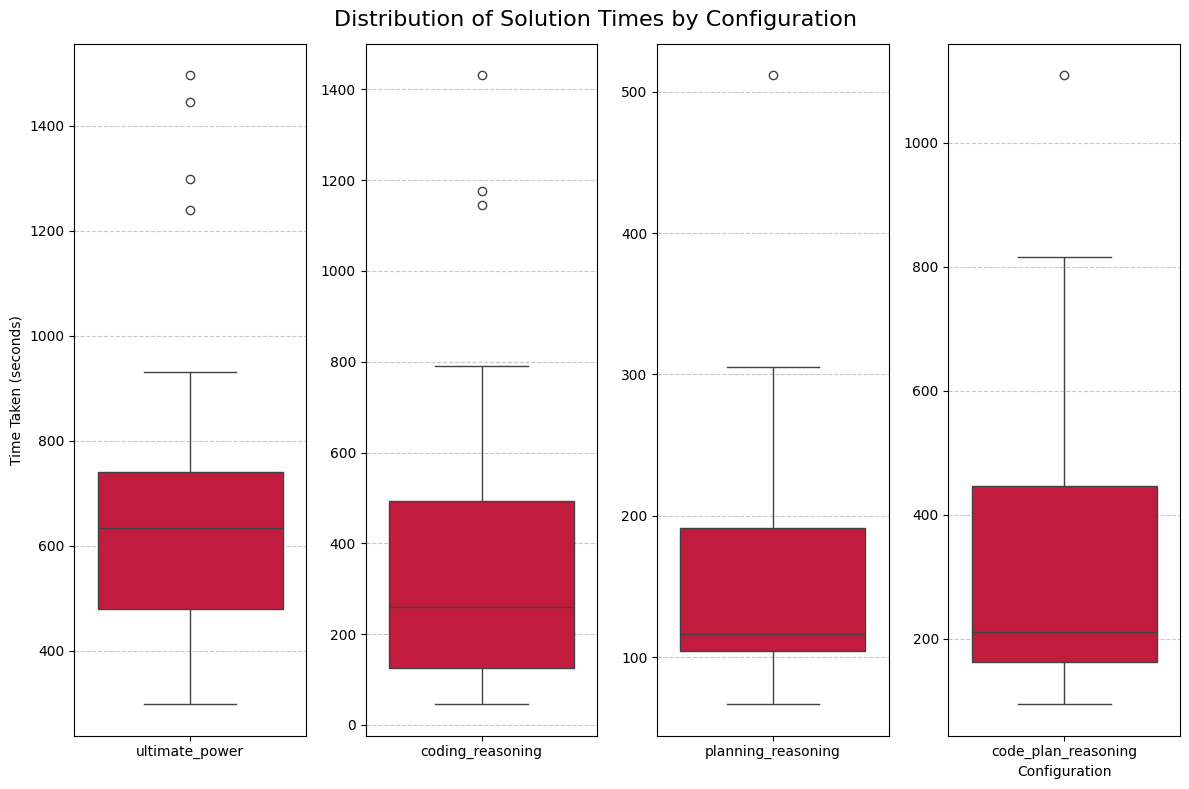

In [9]:

config_name_map = { "ultimate_power": "Config 1 (Power)",
    "planning_reasoning": "Config 2 (Planning Reasoning)",
    "coding_reasoning": "Config 3 (Coding Reasoning)",
    "code_plan_reasoning": "Config 4 (P&C Reasoning)",
}

# Time analysis by configuration
time_by_config = df.groupby('config_name')['time'].agg(['mean', 'median', 'std', 'min', 'max']).reset_index()
time_by_config.columns = ['Configuration', 'Mean Time', 'Median Time', 'Std Dev', 'Min Time', 'Max Time']

# Display the results
print("Time Performance by Configuration (seconds):")
print(time_by_config)

# Create boxplots for each model
plt.figure(figsize=(12, 8))
for i, config_name in enumerate(df['config_name'].unique()):
    plt.subplot(1, len(df['config_name'].unique()), i+1)
    
    config_data = df[df['config_name'] == config_name]
    sns.boxplot(
        x='config_name',
        y='time',
        data=config_data
    ).set(
        xlabel=""
    )
   # plt.title(f'{config_name}')
    
    if i == 0:  # Only add y-label to the first subplot
        plt.ylabel('Time Taken (seconds)')
    else:
        plt.ylabel('')
    
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.xlabel('Configuration')
plt.suptitle('Distribution of Solution Times by Configuration', fontsize=16)
plt.tight_layout()
#plt.subplots_adjust(top=0.88)
plt.show()


Time Performance by Configuration (seconds):
         Configuration   Mean Time  Median Time     Std Dev    Min Time  \
0  code_plan_reasoning  326.318178   211.395903  249.325274   94.840982   
1     coding_reasoning  402.563093   260.774069  381.694246   45.811641   
2   planning_reasoning  156.296327   116.771266   95.854625   66.825072   
3       ultimate_power  706.414030   633.299987  332.033260  297.929070   

      Max Time  
0  1108.427663  
1  1430.515465  
2   511.481929  
3  1495.440613  


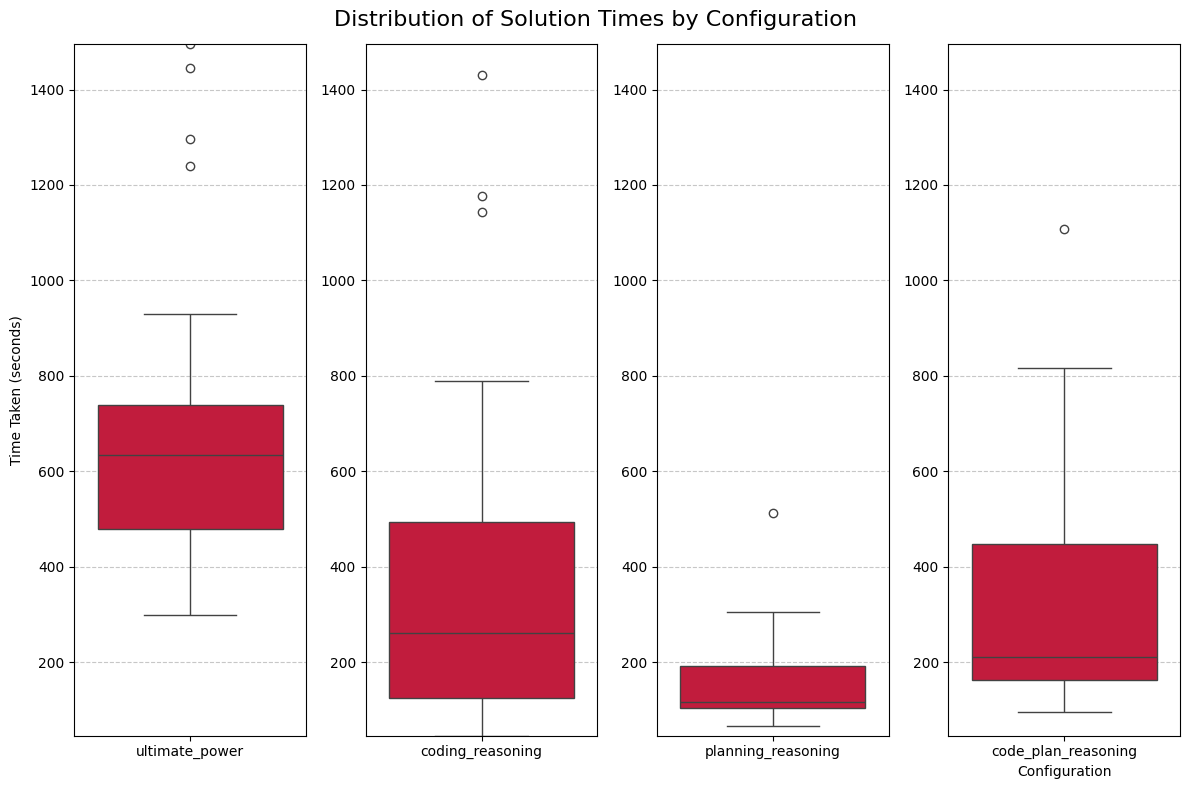

In [ ]:
config_name_map = {
    "ultimate_power": "Config 1 (Power)",
    "planning_reasoning": "Config 2 (Planning Reasoning)",
    "coding_reasoning": "Config 3 (Coding Reasoning)",
    "code_plan_reasoning": "Config 4 (P&C Reasoning)",
}

# Time analysis by configuration
time_by_config = (
    df.groupby("config_name")["time"]
    .agg(["mean", "median", "std", "min", "max"])
    .reset_index()
)
time_by_config.columns = [
    "Configuration",
    "Mean Time",
    "Median Time",
    "Std Dev",
    "Min Time",
    "Max Time",
]

# Display the results
print("Time Performance by Configuration (seconds):")
print(time_by_config)

# Calculate global y-axis limits
y_min = df["time"].min()
y_max = df["time"].max()

# Create boxplots for each model
plt.figure(figsize=(12, 8))
for i, config_name in enumerate(df["config_name"].unique()):
    plt.subplot(1, len(df["config_name"].unique()), i + 1)

    config_data = df[df["config_name"] == config_name]
    sns.boxplot(x="config_name", y="time", data=config_data).set(xlabel="")

    # Set the same y-axis limits for all subplots
    plt.ylim(y_min, y_max)

    if i == 0:  # Only add y-label to the first subplot
        plt.ylabel("Time Taken (seconds)")
    else:
        plt.ylabel("")

    plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.xlabel("Configuration")
plt.suptitle("Distribution of Time Taken by Configuration", fontsize=16)
plt.tight_layout()
save_fig(plt, 'distribution_of_solution_times_model_comp_same_scale')
plt.show()

#### Debug Attempts


--- Average Debug Attempts per Configuration ---
config_name
ultimate_power         0.44
planning_reasoning     1.64
code_plan_reasoning    2.20
coding_reasoning       2.88
Name: debug_attempts, dtype: float64


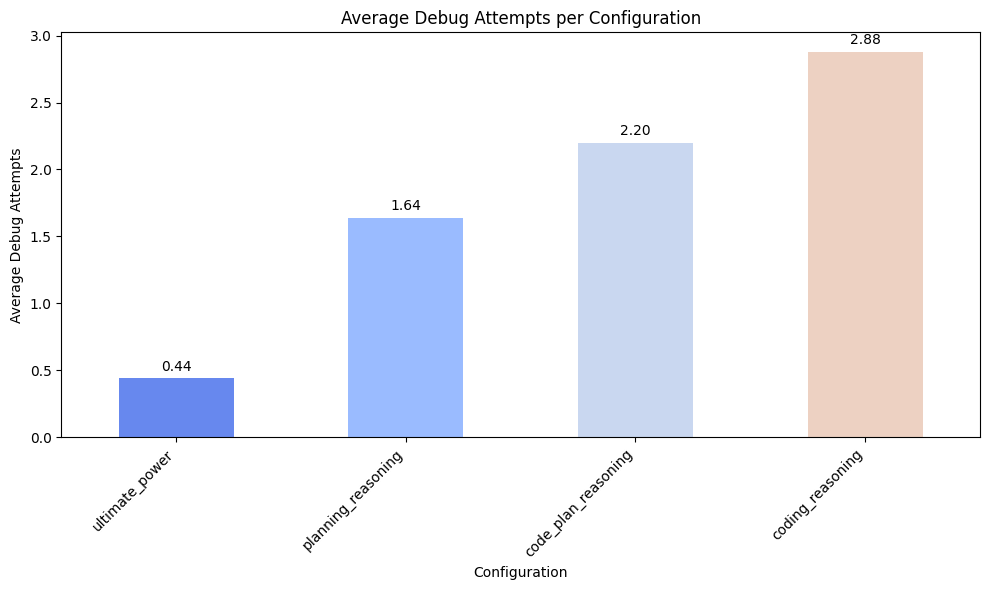

In [11]:
# Calculate average debug attempts per configuration (for all attempts)
avg_debug_attempts_per_config = (
    df.groupby("config_name")["debug_attempts"].mean().sort_values()
)

print("\n--- Average Debug Attempts per Configuration ---")
print(avg_debug_attempts_per_config)

# Plotting
plt.figure(figsize=(10, 6))
avg_debug_attempts_per_config.plot(
    kind="bar", color=sns.color_palette("coolwarm")
)
plt.title("Average Debug Attempts per Configuration")
plt.ylabel("Average Debug Attempts")
plt.xlabel("Configuration")
plt.xticks(rotation=45, ha="right")
# Add attempt labels on top of bars
for i, v in enumerate(avg_debug_attempts_per_config):
    plt.text(i, v + (0.02 * avg_debug_attempts_per_config.max()), f"{v:.2f}", color="black", ha="center")

plt.tight_layout()
plt.show()

##### Debug Suggestions

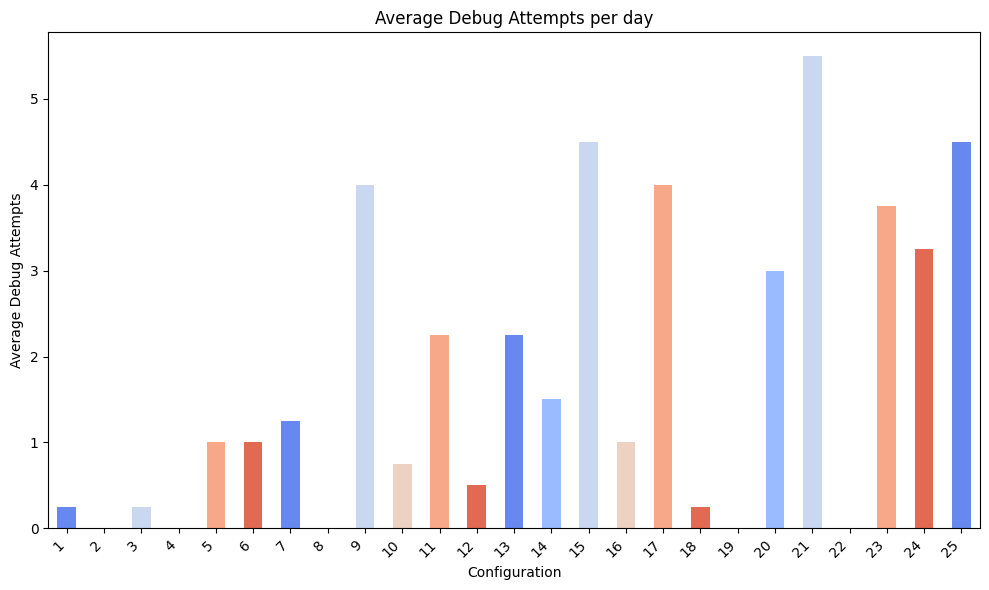

In [12]:
# Debug attempts per day
debug_attempts_by_day = df.groupby("day")['debug_attempts'].mean()

plt.figure(figsize=(10, 6))
debug_attempts_by_day.plot(
    kind="bar", color=sns.color_palette("coolwarm")
)
plt.title("Average Debug Attempts per day")
plt.ylabel("Average Debug Attempts")
plt.xlabel("Configuration")
plt.xticks(rotation=45, ha="right")

plt.tight_layout()
plt.show()


#### Retrieval


--- Average Number of Retrieved Puzzles per Configuration ---
config_name
ultimate_power         1.68
coding_reasoning       2.20
planning_reasoning     2.24
code_plan_reasoning    2.28
Name: n_retreived_puzzles, dtype: float64


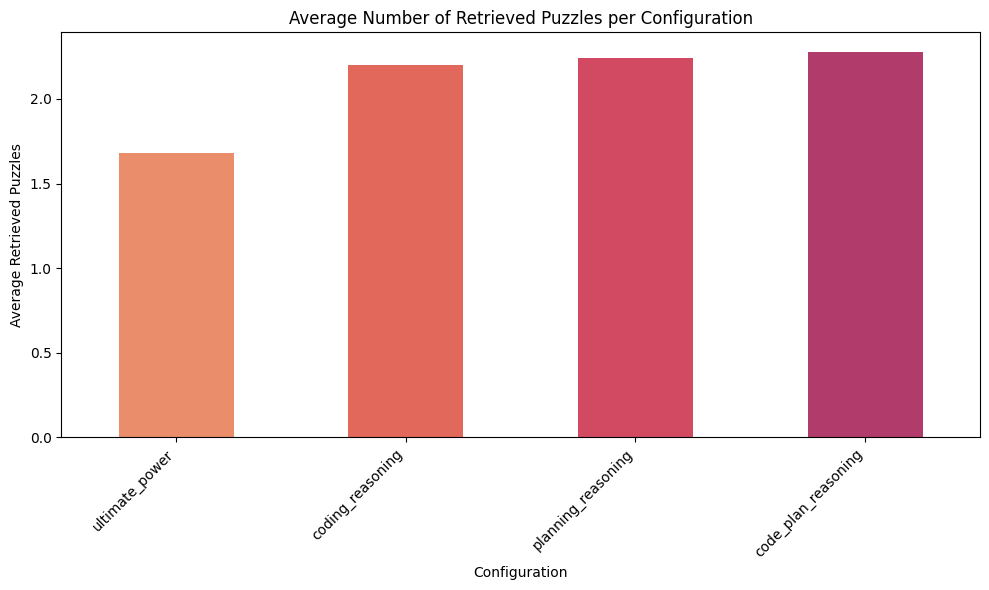


Overall correlation between n_retreived_puzzles and success: 0.10


In [13]:
# Average number of retrieved puzzles per configuration
avg_retrieved_per_config = (
    df.groupby("config_name")["n_retreived_puzzles"].mean().sort_values()
)

print("\n--- Average Number of Retrieved Puzzles per Configuration ---")
print(avg_retrieved_per_config)

plt.figure(figsize=(10, 6))
avg_retrieved_per_config.plot(kind="bar", color=sns.color_palette("flare"))
plt.title("Average Number of Retrieved Puzzles per Configuration")
plt.ylabel("Average Retrieved Puzzles")
plt.xlabel("Configuration")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Correlation between n_retreived_puzzles and success (overall)
# Note: This is a simple correlation; causation is not implied.
# Convert boolean 'success' to int for correlation
correlation_retrieved_success = df["n_retreived_puzzles"].corr(
    df["success"].astype(int)
)
print(
    f"\nOverall correlation between n_retreived_puzzles and success: {correlation_retrieved_success:.2f}"
)

#### Puzzle Difficulty




--- Success Rate per Puzzle (Across All Configurations) ---
day
15    0.25
21    0.25
25    0.25
9     0.50
17    0.50
23    0.50
20    0.50
24    0.50
14    0.75
13    0.75
11    0.75
7     1.00
8     1.00
1     1.00
3     1.00
2     1.00
16    1.00
12    1.00
10    1.00
4     1.00
5     1.00
6     1.00
19    1.00
18    1.00
22    1.00
Name: success, dtype: float64


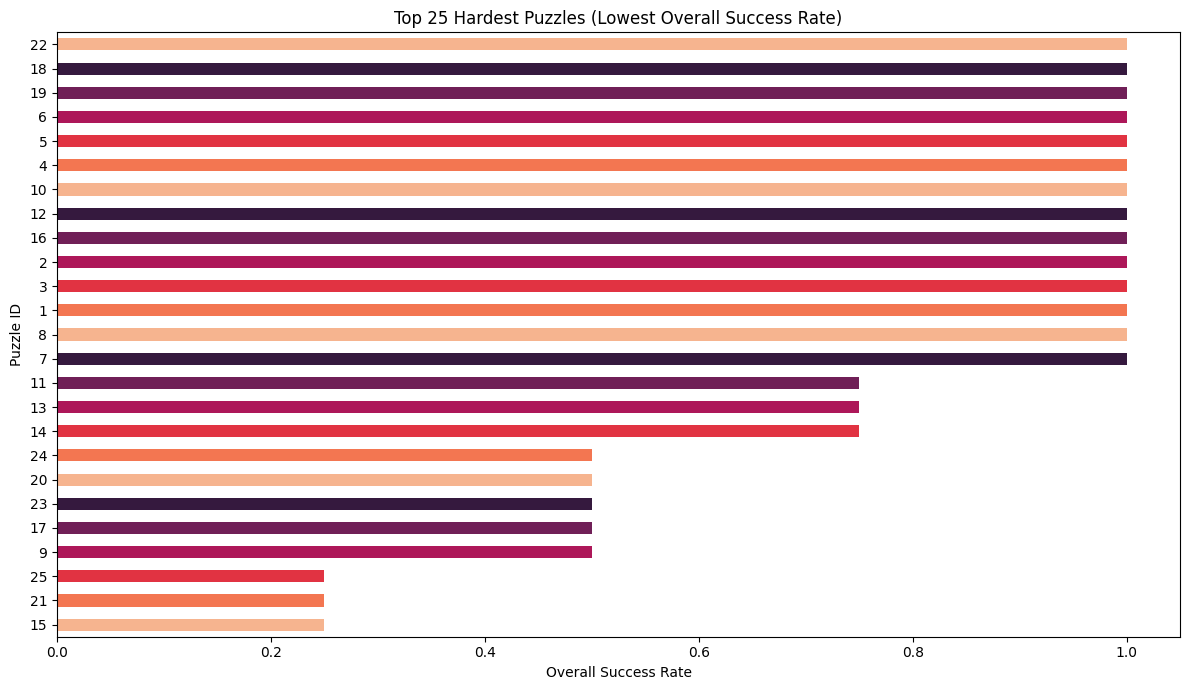

In [14]:
# Success rate per puzzle_id
puzzle_success_rate = (
    df.groupby("day")["success"].mean().sort_values()
) # Sorts by least successful to most

print("\n--- Success Rate per Puzzle (Across All Configurations) ---")
print(puzzle_success_rate)

# Plotting top N hardest puzzles
N_PUZZLES_TO_SHOW = 25 # Adjust as needed
plt.figure(figsize=(12, 7))
puzzle_success_rate.head(N_PUZZLES_TO_SHOW).plot(
    kind="barh", color=sns.color_palette("rocket_r")
)
plt.title(f"Top {N_PUZZLES_TO_SHOW} Hardest Puzzles (Lowest Overall Success Rate)")
plt.xlabel("Overall Success Rate")
plt.ylabel("Puzzle ID")
plt.tight_layout()
plt.show()


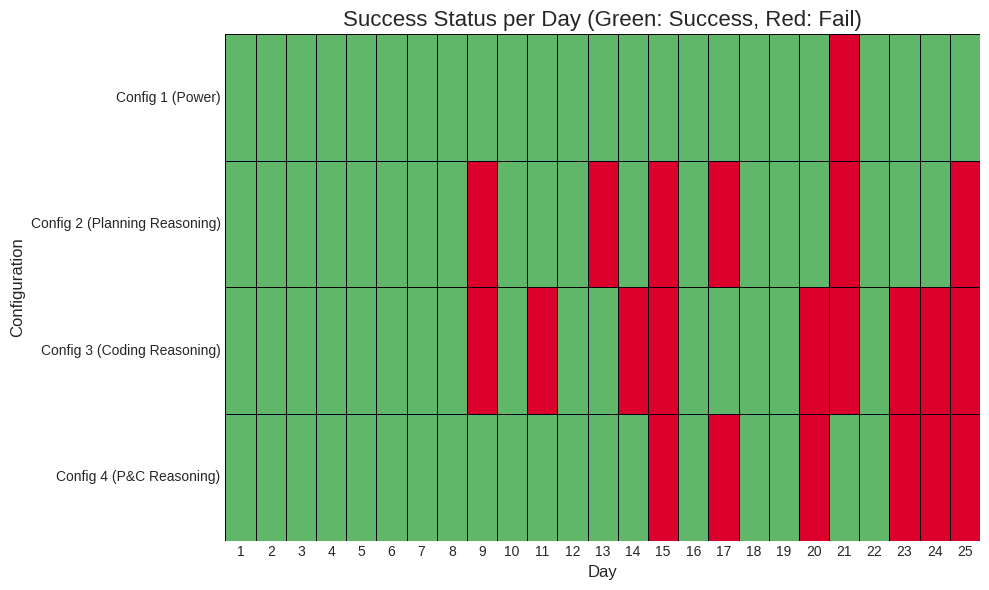

In [15]:
config_name_map = { "ultimate_power": "Config 1 (Power)",
    "planning_reasoning": "Config 2 (Planning Reasoning)",
    "coding_reasoning": "Config 3 (Coding Reasoning)",
    "code_plan_reasoning": "Config 4 (P&C Reasoning)",
}

df['config_name'] = df['config_name'].map(config_name_map)

# Convert success boolean to integer (1 for True, 0 for False) for color mapping
success_data_pivot = df.pivot_table(
    index="config_name", columns="day", values="success", aggfunc="first"
).astype(int)



# Get unique days from the DataFrame to ensure correct labels for x-axis
days = sorted(df['day'].unique())

# --- Plotting Success Heatmap ---
plt.style.use('seaborn-v0_8-darkgrid')

plt.figure(figsize=(10, 6)) # Create a new figure for this plot
ax1 = sns.heatmap(
    success_data_pivot,
    annot=False,     # No annotations for 0/1 values
    fmt=".0f",
    cmap=sns.color_palette(['#dc002d', '#60b669']),
#    cmap="RdYlGn",   # Red for fail (0), Green for success (1)
    cbar=False,      # No color bar for binary values
    linewidths=0.5,
    linecolor="black",
)
ax1.set_title("Success Status per Day (Green: Success, Red: Fail)", fontsize=16)
ax1.set_ylabel("Configuration", fontsize=12)
ax1.set_xlabel("Day", fontsize=12) # Explicitly set x-axis label
ax1.tick_params(axis='y', rotation=0) # Keep y-axis labels horizontal

# Set x-axis ticks and labels for this plot
ax1.set_xticks([i + 0.5 for i in range(len(days))])
ax1.set_xticklabels(days)
ax1.tick_params(axis='x', rotation=0) # Keep x-axis labels horizontal
save_fig(plt, 'heatmap_success_days')
plt.tight_layout()
plt.show()